In [1]:
# Name: example_flash_current_dependence.ipynb
# Authors: Stephan Meighen-Berger
# Example how to check the possible pulse shape changes due to detector positioning and water currents.
# For a proper analysis we recommend to run the simulation with only a single organism type.
# The easiest way to set this up, is to define a custom organism in the life files with some absurd depth
# and then filter out anything above this depth

In [2]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
import imageio
from tqdm import tqdm
import pickle

In [3]:
# Adding path to module
sys.path.append("../")

In [4]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [5]:
# picture path
PICS = '../pics/'

In [6]:
# Module imports
from fourth_day import Fourth_Day, config

In [7]:
# Some example settings
config["scenario"]["class"] = "Stored"
config['scenario']['population size'] = 100
config['scenario']['duration'] = 6000
config['scenario']['organism movement'] = False
config['scenario']['exclusion'] = True
config['scenario']['injection']['rate'] = 1
config['scenario']['injection']['y range'] = [0., 10.]
config['scenario']['light prop'] = {
            "switch": True,
            "x_pos": 5.,
            "y_pos": 10.,
        }
config['scenario']['detector'] = {
    "switch": True,
    "type": "Custom",
    "response": True,
    "acceptance": "Flat",
    "mean detection prob": 0.5
}
# Organisms 
config['organisms']['emission fraction'] = 0.1
config['organisms']['alpha'] = 2.
config['organisms']['photon yield'] = 1e10
config["organisms"]["filter"] = 'depth'
config["organisms"]["depth filter"] = 100000  # Note the absurd depth. This is used to exclusively simulate custom organisms
# Geometry
config['geometry']['volume'] = {
    'function': 'rectangle',
    'x_length': 26.,
    'y_length': 10.,
    'offset': None,
}
config['geometry']['observation'] = {
    'function': 'rectangle',
    'x_length': 26.,
    'y_length': 10.,
    "offset": np.array([0., 0.]),
}
config['geometry']["exclusion"] = {
    "function": "sphere",
    "radius": 0.15,
    "x_pos": 2.,
    "y_pos": 5.,
}
# Water
config['water']['model']['name'] = 'custom' # 'potential cylinder'
config['water']['model']['directory'] = "../data/current/Long_run_corr/"
config['water']['model']['time step'] = 0.1
config['advanced']['starting step'] = 0
# Detector
config["geometry"]["detector properties"]["Custom"] = {
    "x_pos": 2.,
    "y_pos": 5.,
    "det num": 12, #12 pmts numbered by position 
    "x_offsets": np.array(
        [0.1,0.,-0.1,0., 0.12,-0.12,-0.12,0.12, 0.2,-0.04,-0.2,0.04]
    ) / 2., #test radius 0.3 meter, real radius 0.15 meter
    "y_offsets": np.array(
        [0.,0.1,0.,-0.1,  0.12,0.12,-0.12,-0.12, 0.04,0.2,-0.04,-0.2]
    ) / 2.,
    "angle offset": 90.,  # In which direction the detector points
    "opening angle": 25.,  # 25., # from dark box rotation test result: +-25 degrees
    "wavelength acceptance": [ #position number,center wavelength,quantum efficiency
        [395., 405.,0.26], #0,400
        [505., 515.,0.16], #1,510
        [420., 430.,0.28], #2,425
        [465., 475.,0.23], #3,470
        [300., 600.,1.], #4,no filter
        [487., 497.,0.1], #5,492
        [540., 560.,0.1], #6,550
        [515., 535.,0.13], #7,525
        [475., 485.,0.2], #8,480
        [445., 455.,0.2], #9,450
        [455., 465.,0.23], #10,460
        [325., 375.,0.3], #11,350                                     
    ],
}

In [8]:
# Which detectors we want to use for the analysis
wavelengths = {
    "Detector 1": ["1", "#4575b4"],
    "Detector 5": ["2", "#91bfdb"],
    "Detector 8": ["3", "#e0f3f8"],
    "Detector 3": ["4", "#fee090"],
    "Detector 10": ["5", "#fc8d59"],
}

In [9]:
# Launching multiple simulations to use in the analysis
seed = 1337
# General
config["general"]["random state seed"] = seed
# Creating a fourth_day object
fd = Fourth_Day()

In [10]:
# Launching solver
fd.sim()

Number of peaks
285
Mean
0.30000001192092896
Sd
3.0


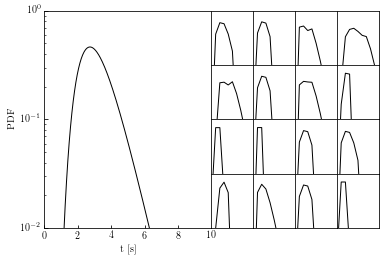

In [338]:
# Fetching relevant data
# Totals
totals = fd.measured["Detector 1"].values
for detector in wavelengths.keys():
    if detector == "Detector 1":
        continue
    fd.measured[detector].values
    totals += fd.measured[detector].values
# Pre-processing results
# Depending on the setup these values do need to be changed
totals = totals  # The simulation has a "warm-up" phase. This depends on the water current. One cycle is recommended
min_val = 1e0
max_val = 1e3
totals[totals < min_val] = 0.  # Depending on the setup the cut-off needs to be lowered or increased
totals[totals > max_val] = 0.
# Smoothing function for plotting
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
# Plotting standards
std_size = 3.
fontsize = 10.
lw=1.
h_length=0.2
# Searching for peaks
from itertools import groupby
import matplotlib.gridspec as gridspec
peaks = [list(v) for k,v in groupby(totals, key = lambda x: x != 0) if k != 0]
number_of_peaks = len(peaks)
peak_order = np.arange(len(peaks))
print("Number of peaks")
print(number_of_peaks)
# The appearing pulse shapes
# Plot figure with subplots of different sizes
fig = plt.figure(1)
# set up subplot grid
gridspec.GridSpec(4,8)
# ---------------------------------------------------------------------------------------------------
# Plot parameters
ylow = 1e-2
yhigh = 1e0
xlow = 0
xhigh = 10
# ---------------------------------------------------------------------------------------------------
# Original 
plt.subplot2grid((4,8), (0,0), colspan=4, rowspan=4)
# The original pulse shape
mean = fd.statistics[-1]["pulse mean"].values[0]
sd = fd.statistics[-1]["pulse sd"].values[0]
print("Mean")
print(mean)
print("Sd")
print(sd)
from fourth_day.pdfs import construct_pdf
pdf = construct_pdf({
    "class": "LogNorm",
    "mean": mean,
    "sd": sd
})
x_grid = np.linspace(0., 20. * 10., 1000 * 10)
# The appearing pulse shapes
plt.plot(
    x_grid,
    pdf.pdf(x_grid),
    lw=lw, color='k')
plt.xscale('linear')
plt.yscale('log')
plt.xlabel(r'$\mathrm{t}\;[\mathrm{s}]$', fontsize=fontsize)
plt.ylabel(r'$\mathrm{PDF}$', fontsize=fontsize)
plt.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
plt.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
# ax1.grid(True)
# Removing ticks
plt.ylim(ylow, yhigh)
plt.xlim(xlow, xhigh)
# ---------------------------------------------------------------------------------------------------
# Peaks found in the simulation
# peaks_arr = [51, 52, 54, 56, 57, 59, 31, 40, 63, 70, 66, 1, 15, 3, 4, 5]
peaks_arr = np.random.randint(0, len(peaks), 16)
counter = 0
row_counter = 0
for _, peak in enumerate(np.array(peaks)[peaks_arr]):
    # print((row_counter,4 + np.mod(counter, 4)))
    plt.subplot2grid((4,8), (row_counter,4 + np.mod(counter, 4)))
    if np.mod(counter, 4) == 3:
        row_counter +=1
    peak_id = counter
    peak.insert(0, ylow)
    peak.append(ylow)
    peak.append(ylow)
    try:
        peak = peak[:18]
        peak.append(ylow)
        peak.append(ylow)
        # print(peak)
        plt.plot(
        np.arange(len(peak[:20])),
        smooth(peak[:20], 2) / np.trapz(smooth(peak, 1)[:20], x=np.arange(len(peak[:20]))),
        lw=lw, color='k')
    except:
        plt.plot(
            np.arange(len(peak)),
            smooth(peak, 1) / np.trapz(smooth(peak, 1), x=np.arange(len(peak))),
            lw=lw, color='k')
    plt.xscale('linear')
    plt.yscale('log')
    # Removing ticks
    plt.xticks([])
    plt.xticks([], minor=True)
    plt.yticks([])
    plt.yticks([], minor=True)
    plt.ylim(ylow, yhigh)
    plt.xlim(xlow, xhigh)
    # plt.xlabel([])
    # plt.xlabel([])
    counter += 1
# ---------------------------------------------------------------------------------------------------
plt.subplots_adjust(wspace=0, hspace=0)
# plt.tight_layout()
plt.show()
fig.savefig(PICS + "MC_Peaks_Ortho.pdf",
            bbox_inches='tight')